In [1]:
using DataFrames, PyPlot, PyCall
include("fitsdf.jl")
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
;

┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/JLD2/O1EyT.ji for JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1184
┌ Info: Precompiling Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
└ @ Base loading.jl:1186


In [2]:
df = fitsdf("distributed_topsnr_test.classified.fits", 2);

,obsid,diff
,Int64,SubArray…
1,96505024,"[-0.0066067, 0.0232053, 0.0365546, 0.00388181, 0.0208494, 0.0146171, 0.0339358, 0.0144067, 0.00236237]"
2,74516223,"[-0.00164831, 0.00997305, -0.0032829, -0.0021618, 0.00879049, -0.000329971, 0.00250125, -0.0051797, -0.00430024]"
3,301615250,"[0.00422072, -0.000397325, 0.045256, 0.00977451, -0.00663769, -0.0423602, -0.038806, 0.0146358, 0.028241]"
4,458215077,"[-0.000439763, -0.00140846, -0.000828624, 0.00169253, 0.00262249, 0.00324035, 0.000832677, 0.00139487, 4.68493e-5]"
5,170402050,"[-0.00145698, 0.00074935, 0.00540143, 0.000629067, -0.000103116, 0.000550389, 0.000747085, -0.00071764, -0.00147873]"
6,140305228,"[0.00111926, -0.00278902, 0.00169659, -0.000648618, 0.00350761, -0.00172889, 0.00882435, 0.0192673, 0.00360036]"
7,19104024,"[0.000672817, 0.046746, 0.0820087, -0.0231363, -0.0788336, -0.111868, -0.0777507, -0.00316346, -0.0602591]"
8,302508093,"[0.00979984, -0.00784063, 0.00990498, 0.00397962, -0.00828278, -0.0132846, 0.00240505, -0.00291097, 0.0103533]"
9,460316247,"[-0.00557494, -0.00159705, -0.022885, 0.0270137, 0.0112622, 0.0266722, -0.0147673, 0.0499885, 0.00803488]"


In [5]:
df.ismatch = df.isline .& (df.delta_chi2 .> 50) .& (df.amplitude .> 0)
sum(df.ismatch)

698

In [22]:
include("get_lamost_spectra.jl")
outliers = df[df.ismatch, :obsid]
neighbors = reduce(vcat, df[df.ismatch, :neighbors])
download_lamost_spectra(Set(outliers) ∪ Set(neighbors), verbose=false);

of 1132 spectra, 0 need to be downloaded


In [26]:
reference = Dict()
for obsid in neighbors
    wl, f, ivar = load_lamost_spectrum(obsid)
    reference[obsid] = f
end

In [73]:
residuals = map(eachrow(df[df.ismatch, :])) do row
    F = hcat((n->reference[n]).(row.neighbors)...)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    (flux - F*row.weights) #.* sqrt.(ivar)
end
;

698-element Array{Array{Float32,1},1}:
 [-1.25324, -1.70557, -1.78215, -1.36292, -0.793991, -0.408794, -0.23934, -0.114333, -0.161181, -0.083526  …  -0.000777125, 0.0159287, 0.019913, 0.0102035, 0.00664365, -0.00406104, 0.00327557, -0.00277126, -0.00461221, -0.00983274]                        
 [-0.0571097, -0.0450852, -0.00102943, 0.0124577, -0.000533402, -0.00727671, -0.00537962, -0.0349666, -0.0282008, 0.0118936  …  -0.00362998, 0.00377834, -0.00625116, -0.00745702, -0.00615537, 0.0012477, 0.00693041, 0.00782919, 0.0115209, 0.00907773]      
 [-0.0608474, -0.0463881, -0.0205827, -0.0176437, -0.0294446, -0.0499461, -0.0545911, -0.038608, -0.0327708, -0.025709  …  -0.00927848, 0.00558019, 0.00944746, 0.00849122, -0.000774741, -0.000482142, 0.00469124, 0.00937456, 0.0124416, 0.00973761]         
 [-0.075224, -0.0289137, -0.00413901, -0.0120119, -0.016488, 0.0593683, 0.0212208, -0.014421, -0.00278938, 0.0368969  …  0.0128554, 0.00372374, 0.0140387, 0.0165002, 0.00857788, 0.00873119, 0.0

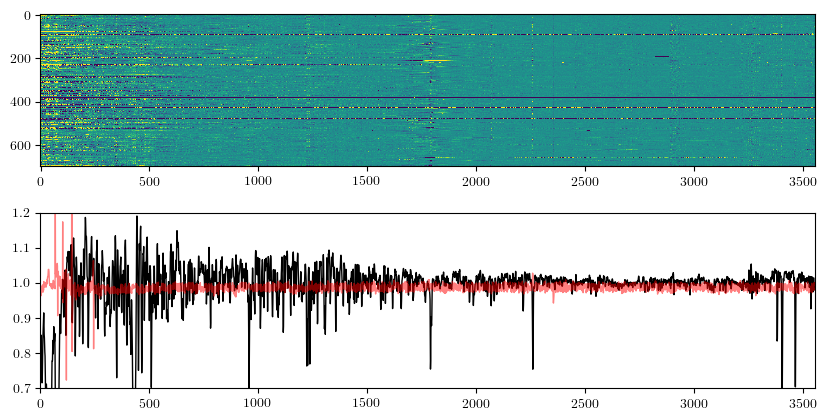

(0, 3559)

In [76]:
axs = subplots(2, 1, figsize=(10, 5))[2]
sca(axs[1])
imshow(reduce(vcat, transpose.(residuals)), vmin=-0.1, vmax=0.1)
sca(axs[2])
plot(rand(reference)[2], lw=1, c="k")
plot(mean(residuals) .+ 1, c="r", lw="1", alpha=0.5)
ylim(0.7, 1.2)
xlim(0, length(residuals[1]))